In [1]:
import logging
import sys
import os

import zipfile

import importlib

from six.moves import urllib
from shutil import copy2

import matplotlib.pyplot as plt

import cv2

import numpy as np

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

import glob

from sklearn.model_selection import train_test_split

import pickle

In [2]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from keras import regularizers

Using TensorFlow backend.
C:\Users\Usrer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Usrer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Usrer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Usrer\Anaconda3\envs\tf_gpu\lib\sit

In [3]:
batch_size = 128
num_classes = 2
epochs = 25

# input image dimensions
#img_rows, img_cols = 48, 48
img_rows, img_cols = 96, 96

In [4]:
def getData():
    all_x = []
    all_y = []

    for imgfilepath in glob.glob("/workspace/dataset/*.jpg"):
        
        maskfilepath = os.path.join("/workspace/dataset/markup", os.path.basename(imgfilepath) + ".png")
        
        sys.stdout.write('\r>> Processing %s %s         ' % (imgfilepath, maskfilepath))
        sys.stdout.flush()

        #names = line.split()

        # load the image and apply SLIC and extract (approximately)
        image = cv2.imread(imgfilepath)
        #image = cv2.resize(image, (1280, 720))
        segments = slic(img_as_float(image), n_segments = 200, sigma = 5)

        image2 = cv2.imread(maskfilepath)
        #image2 = cv2.resize(image2, (1280, 720))
        magenta = np.array([1, 1, 1], dtype=np.uint8)

        mask2 = np.all(image2 == magenta, axis = -1)
        
        #plt.figure()
        #plt.imshow(image)
        #plt.figure()
        #plt.imshow(mask2)    

        # loop over the unique segment values
        for (i, segVal) in enumerate(np.unique(segments)):
            # construct a mask for the segment
            mask = np.zeros(image.shape[:2], dtype = "uint8")
            mask[segments == segVal] = 255

            m = cv2.moments(mask, True);

            x = m["m10"]/m["m00"]
            y = m["m01"]/m["m00"]

            intersection = np.logical_and(mask, mask2)

            img = cv2.bitwise_and(image, image, mask = mask)

            #crop
            img = img[int(y - img_rows/2) : int(y + img_rows/2), 
                      int(x - img_cols/2) : int(x + img_cols/2)]

            old_size = img.shape[:2]
            delta_w = img_cols - old_size[1]#img.cols
            delta_h = img_rows - old_size[0]#img.rows
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)


            value = int(np.sum(intersection) > m["m00"] / 2)

            all_x.append([img])
            all_y.append([value])

            #flipHorizontal = cv2.flip(img, 1)
            #all_x.append([flipHorizontal])
            #all_y.append([value])
            
            
            #break
        #break

    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)

    return all_x, all_y

In [5]:
# the data, split between train and test sets

(X, y) = getData()


#(x_train, y_train) = getData(train_txt)
#(x_test, y_test) = getData(val_txt)

>> Processing /workspace/dataset\2.jpg /workspace/dataset/markup\2.jpg.png         ataset/markup\192.168.1.64_01_20190521152106867.jpg.png         

In [7]:
with open('x_y_data.pickle', 'wb') as f:
    pickle.dump([X, y], f)

In [4]:
with open('x_y_data.pickle', 'rb') as f:
    X, y = pickle.load(f)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [6]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

#x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (67462, 96, 96, 3)
y_train shape: (67462,)
67462 train samples
16866 test samples


In [8]:
l2 = regularizers.l2(0.01)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 kernel_regularizer=l2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#model.fit(x_train, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
        # must be used with rescale
        brightness_range=(0.9,1.1),
        rescale = 1./255,
        horizontal_flip=True, fill_mode="constant", cval=0)

#early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# train the network
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // epochs,
        epochs=epochs, verbose=1)
        #callbacks=[early_stopping])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
2698/2698 [==============================] - 786s 291ms/step - loss: 0.3219 - accuracy: 0.9424 - val_loss: 0.2581 - val_accuracy: 0.9329
Epoch 2/25
2698/2698 [==============================] - 794s 294ms/step - loss: 0.2096 - accuracy: 0.9550 - val_loss: 0.2623 - val_accuracy: 0.9303
Epoch 3/25
2698/2698 [==============================] - 802s 297ms/step - loss: 0.1992 - accuracy: 0.9563 - val_loss: 0.2340 - val_accuracy: 0.9412
Epoch 4/25
2698/2698 [==============================] - 817s 303ms/step - loss: 0.1939 - accuracy: 0.9570 - val_loss: 0.4288 - val_accuracy: 0.8626
Epoch 5/25
2698/2698 [==============================] - 778s 288ms/step - loss: 0.1889 - accuracy: 0.9580 - val_loss: 0.3037 - val_accuracy: 0.9101
Epoch 6/25
2698/2698 [==============================] - 775s 287ms/step - loss: 0.1876 - accuracy: 0.9586 - val_loss: 0.3141 - val_accuracy: 0.9048
Epoch 7/25
2698/2698 [==============================] - 795s 295ms/step - loss: 0.1850 - accuracy: 0.9592 - val_

In [9]:
model.save('my_model.h5')

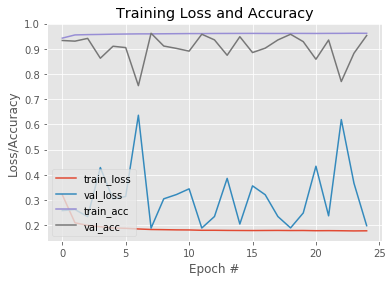

In [10]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")